# Advanced Machine Learning
## Project 2: Deep Reinforcement Learning
## Group 4

Fatma Özel, nº 57037 <br>
Nuno Costa, nº 58635


## Introduction

In this project, we will train and compare three different reinforcement learning agents: Q-learning, Deep Q-network (DQN), and Soft Actor-Critic (SAC). We will use the MountainCar-v0 environment from Gymnasium.


## Setup and Imports

In [3]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import gymnax
import jax
import time
from RLinJAX import *

In [20]:
def discretize_state(state, position_bins, velocity_bins):
    """Convert continuous state to discrete bins."""
    position, velocity = state
    pos_idx = np.clip(np.digitize(position, bins=position_bins) - 1, 0, len(position_bins) - 1)
    vel_idx = np.clip(np.digitize(velocity, bins=velocity_bins) - 1, 0, len(velocity_bins) - 1)
    return int(pos_idx), int(vel_idx)

### Part 1: Train a Q-learning Agent
#### Environment Setup and Discretization

In [21]:
# Load MountainCar environment
env = gym.make('MountainCar-v0')

# Discretize position and velocity
position_bins = np.linspace(-1.2, 0.6, num=30)  # Increased to 30 bins for position
velocity_bins = np.linspace(-0.07, 0.07, num=30)  # Increased to 30 bins for velocity

#### Q-learning Algorithm Implementation

In [22]:
# Initialize Q-table
num_actions = env.action_space.n  # MountainCar has 3 actions

q_table = {}
for position in range(len(position_bins)):
    for velocity in range(len(velocity_bins)):
        for action in range(num_actions):
            q_table[(position, velocity, action)] = 0.0  # Initialize Q-values to 0.0

# Epsilon-greedy policy
def epsilon_greedy(state, epsilon):
    """Choose an action using epsilon-greedy policy."""
    pos_idx, vel_idx = state
    if random.uniform(0, 1) < epsilon:
        action = random.choice(range(num_actions))
    else:
        action = np.argmax([q_table[(pos_idx, vel_idx, action)] for action in range(num_actions)])
    return action

#### Training the Q-learning Agent

In [50]:
# Q-learning parameters
alpha = 0.1  # Decreased learning rate
gamma = 0.99  # Increased discount factor
epsilon = 1.0  # Start with high exploration
epsilon_decay = 0.9992 # Decay epsilon
min_epsilon = 0.005
num_episodes = 10000  # Increased number of episodes
num_steps = 200

# Training loop
rewards = []
for i in range(num_episodes):
    s, _ = env.reset()
    s = discretize_state(s,  position_bins, velocity_bins)  # Discretize the initial state
    total_reward = 0

    for t in range(num_steps):
        # Select action using epsilon-greedy policy
        a = epsilon_greedy(s, epsilon)

        # Take the action and observe the next state and reward
        s_, r, done, _, _ = env.step(a)
        s_ = discretize_state(s_,  position_bins, velocity_bins)

        # Update Q-value using Bellman equation
        best_next_action = np.argmax([q_table[(s_[0], s_[1], action)] for action in range(num_actions)])  # Max Q-value for next state
        q_table[(s[0], s[1], a)] += alpha * (r + gamma * q_table[(s_[0], s_[1], best_next_action)] - q_table[(s[0], s[1], a)])

        # Update state
        s = s_
        total_reward += r

        # Break if terminal state is reached
        if done:
            break

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    rewards.append(total_reward)
    if (i + 1) % 200 == 0:
        print(f"Episode {i + 1}/{num_episodes}: Total Reward = {total_reward}, Epsilon = {epsilon:.3f}")

env.close()

Episode 200/10000: Total Reward = -200.0, Epsilon = 0.852
Episode 400/10000: Total Reward = -200.0, Epsilon = 0.726
Episode 600/10000: Total Reward = -200.0, Epsilon = 0.619
Episode 800/10000: Total Reward = -197.0, Epsilon = 0.527
Episode 1000/10000: Total Reward = -200.0, Epsilon = 0.449
Episode 1200/10000: Total Reward = -164.0, Epsilon = 0.383
Episode 1400/10000: Total Reward = -157.0, Epsilon = 0.326
Episode 1600/10000: Total Reward = -178.0, Epsilon = 0.278
Episode 1800/10000: Total Reward = -145.0, Epsilon = 0.237
Episode 2000/10000: Total Reward = -147.0, Epsilon = 0.202
Episode 2200/10000: Total Reward = -151.0, Epsilon = 0.172
Episode 2400/10000: Total Reward = -150.0, Epsilon = 0.146
Episode 2600/10000: Total Reward = -184.0, Epsilon = 0.125
Episode 2800/10000: Total Reward = -141.0, Epsilon = 0.106
Episode 3000/10000: Total Reward = -153.0, Epsilon = 0.091
Episode 3200/10000: Total Reward = -146.0, Epsilon = 0.077
Episode 3400/10000: Total Reward = -142.0, Epsilon = 0.066
E

#### Visualization

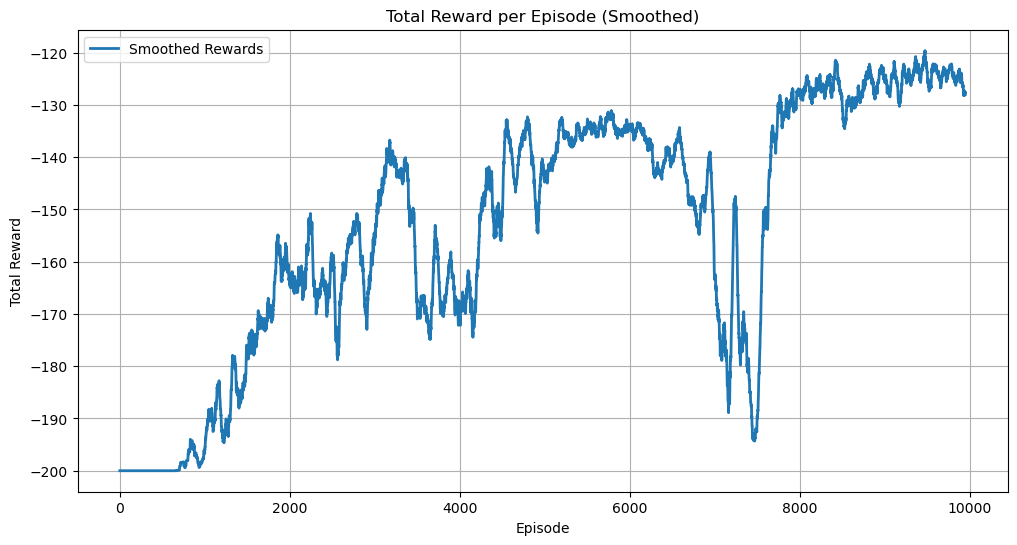

In [51]:
# Smooth rewards using moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(rewards, window_size=50)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(smoothed_rewards, label='Smoothed Rewards', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()



# def simple_moving_average(data, window):
#     return np.convolve(data, np.ones(window), 'valid') / window

# window_size = 100
# sma_rewards = simple_moving_average(rewards, window_size)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(sma_rewards)
# plt.title('Simple Moving Average Reward (window=100)')
# plt.xlabel('Episode')
# plt.ylabel('SMA Reward')


# plt.tight_layout()
plt.show()

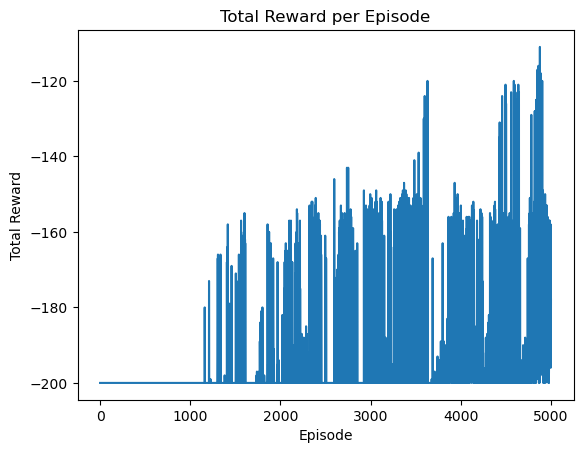

In [12]:
# Plotting the results
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

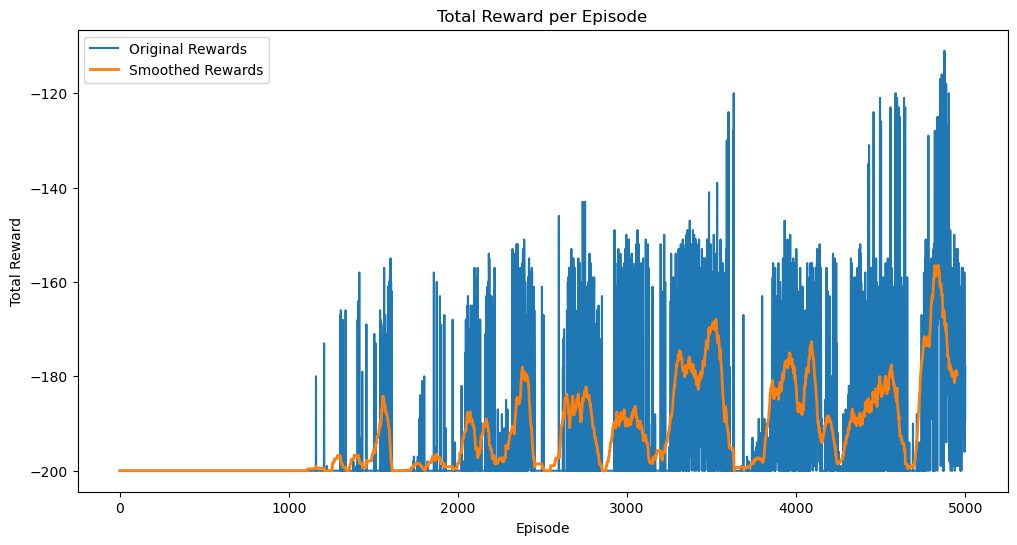

In [13]:
# Smooth rewards using moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(rewards, window_size=50)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Original Rewards')
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label='Smoothed Rewards', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.show()

### Part 2: Train a Deep Q-network (DQN) Agent

#### Introduction to Deep Reinforcement Learning with JAX

####  Mountain Car environment

In [51]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the MountainCar-v0' environment
env, env_params = gymnax.make('MountainCar-v0')
# inspect default environment settings
print("Environment parameters:", env_params)

Environment parameters: EnvParams(max_steps_in_episode=200, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.5, goal_velocity=0.0, force=0.001, gravity=0.0025)


In [52]:
# Verify observation and action space
print("Action Space Size:", env.num_actions)

Action Space Size: 3


In [53]:
# observation space dimensionality
env.observation_space(env_params).shape

(2,)

In [54]:
# action space dimensionality
env.action_space(env_params).n

3

In [55]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.58275205,  0.        ], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), position=Array(-0.58275205, dtype=float32), velocity=Array(0., dtype=float32, weak_type=True)))

In [56]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

/opt/anaconda3/envs/TPML/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([-5.8331072e-01, -5.5867527e-04], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5833107, dtype=float32), velocity=Array(-0.00055868, dtype=float32)),
 Array(-1., dtype=float32, weak_type=True),
 Array(False, dtype=bool))

In [57]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

/opt/anaconda3/envs/TPML/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [58]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))

num_envs = 8
vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys, env_params)
n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, jax.numpy.zeros(num_envs), env_params)
print(n_obs.shape)

(8, 2)


In [59]:
jax.devices()

[CpuDevice(id=0)]

In [60]:
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x3344c8e10>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 131072,
 'learning_rate': 0.0003,
 'gamma': 0.95,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 1,
 'polyak': 0.99,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'eps_start': 1.0,
 'eps_end': 0.05,
 'exploration_fraction': 0.1,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 3,
  'parent': None,
  'name': None},
 'num_epochs': 1,
 'ddqn': True}

#### Setting up the training configuration

In [61]:
# CONFIGS = { "dqn": {
#             "agent": "DuelingQNetwork",
#             "agent_kwargs": {"activation": "swish"},
#         "buffer_size": 100000,
#         "fill_buffer": 1000,
#         "batch_size": 100,
#         "learning_rate": 3e-4,
#         "polyak": 0.98, 
#         "target_update_freq": 200,
#         "total_timesteps": 120000,
#         "eval_freq": 5000,
#         "eps_start": 1.0,
#         "eps_end": 0.01,
#         "exploration_fraction": 0.5,
#         "gamma": 0.9,
#         'num_epochs': 1,
#         'ddqn': True}
#          }
        

CONFIGS = {
    'env': None,  # Placeholder for the environment object
    'env_params': {},  # Placeholder for environment parameters
    'eval_callback': None,  # Placeholder for the evaluation callback function
    'eval_freq': 5000,
    'skip_initial_evaluation': False,
    'total_timesteps': 120000,
    'learning_rate': 0.0003,
    'gamma': 0.95,
    'max_grad_norm': 10.0,  # Avoid inf if unsupported
    'normalize_observations': False,
    'target_update_freq': 200,
    'polyak': 0.98,  # Avoid setting to None
    'num_envs': 1,
    'buffer_size': 100000,
    'fill_buffer': 1000,
    'batch_size': 100,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'exploration_fraction': 0.5,
    'num_epochs': 10,  # Add a valid value or handle None
    'ddqn': True,
    'agent': 'DuelingQNetwork',
    'agent_kwargs': {
        'activation': 'swish'
    }
}



#### Let's create the algorithm instance for DQN in the MountainCar-v0 environment:

In [62]:
algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

#### Updating Algorithm Parameters

In this section, we demonstrate how to update the parameters of the reinforcement learning algorithm. Specifically, we will change the discount factor (`gamma`) of the algorithm and print the updated value.


In [63]:
algo = algo.replace(gamma=0.95)
print(f"New gamma: {algo.gamma}")

New gamma: 0.95


#### Training the DQN Agent

In [64]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


/opt/anaconda3/envs/TPML/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/opt/anaconda3/envs/TPML/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 6.51648 seconds (20113.9 steps/second).


In [65]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [200, 200, 200, ..., 200, 200, 200],
        [134, 200, 200, ...,  90,  87, 197],
        [165, 149, 200, ..., 200, 200, 200]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-134., -200., -200., ...,  -90.,  -87., -197.],
        [-165., -149., -200., ..., -200., -200., -200.]],      dtype=float32, weak_type=True))

#### Visualization

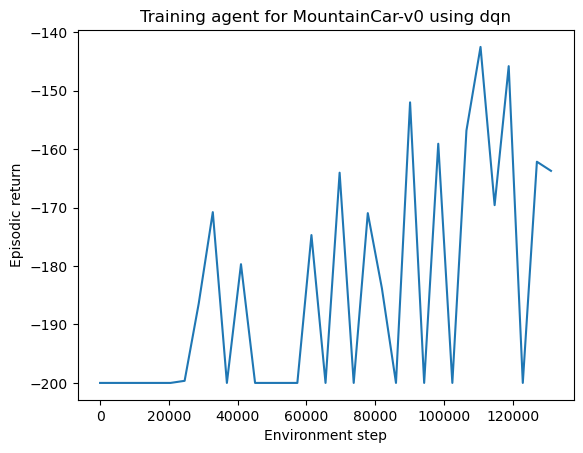

In [29]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

### Part 3: Train a Soft Actor-Critic (SAC) Agent

#### Setting up the training configuration

In [4]:
CONFIGS = {
    'env': 'MountainCar-v0',  # Environment ID
    'env_params': {},  # Placeholder for environment-specific parameters
    'eval_freq': 10,  # Evaluate every 10 episodes
    'skip_initial_evaluation': False,
    'total_timesteps': 200000,  # Total timesteps for training
    'learning_rate': 0.0003,  # Learning rate (actor/critic can be separate if needed)
    'gamma': 0.99,  # Discount factor
    'max_grad_norm': 10.0,  # Maximum gradient norm
    'normalize_observations': False,  # Normalize observations if needed
    'target_update_freq': 200,  # Target network update frequency
    'polyak': 0.005,  # Polyak averaging coefficient
    'num_envs': 1,  # Single environment for SAC
    'buffer_size': 100000,  # Replay buffer size
    'fill_buffer': 1000,  # Minimum steps to fill buffer before training
    'batch_size': 100,  # Batch size for updates
    'eps_start': 1.0,
    'eps_end': 0.01,
    'exploration_fraction': 0.5,
    'num_epochs': 10,  # Number of epochs for training
    'ddqn': False,  # Not relevant for SAC
    'agent': 'SAC',  # Specify the SAC agent
    'agent_kwargs': {
        'activation': 'relu',  # Activation function
        'target_entropy_ratio': 0.98,  
        'num_critics': 2,  # Number of critic networks
        'actor_lr': 0.0003,  # Actor learning rate
        'critic_lr': 0.0003,  # Critic learning rate
        'alpha_lr': 0.0003,  # Temperature parameter learning rate
        'initial_alpha': 0.2,  # Initial temperature value
        'target_entropy': None,  # Defaults to -action_dim if not set
    }
}


#### Let's create the algorithm instance for SAC in the MountainCar-v0 environment:

In [5]:
algo_str = "sac" 
env_str = "MountainCar-v0"  

algo_cls = get_algo(algo_str)

algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

#### Adjusting the Target Entropy Ratio

In [6]:
algo = algo.replace(target_entropy_ratio=0.55)
print(f"New target_entropy_ratio: {algo.target_entropy_ratio}")

New target_entropy_ratio: 0.55


#### Training the SAC Agent

In [7]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


/opt/anaconda3/envs/TPML/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 10.3339 seconds (12683.7 steps/second).


In [8]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [200, 163, 160, ..., 156, 172, 163],
        [159, 195, 151, ..., 160, 107, 100],
        [151, 151, 152, ...,  86, 152, 159]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -163., -160., ..., -156., -172., -163.],
        [-159., -195., -151., ..., -160., -107., -100.],
        [-151., -151., -152., ...,  -86., -152., -159.]],      dtype=float32, weak_type=True))

#### Visualization

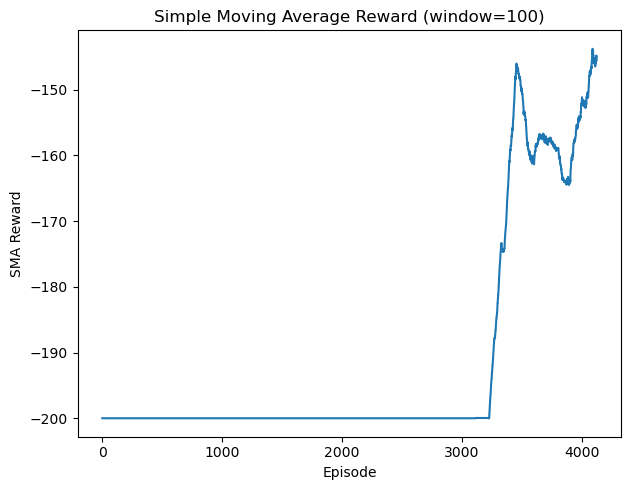

In [19]:
# from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
episode_returns_2 = np.concatenate(episode_returns)

# mean_return = episode_returns.mean(axis=1)

# plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
# plt.xlabel("Environment step")
# plt.ylabel("Episodic return")
# plt.title(f"Training agent for {env_str} using {algo_str}")
# plt.show()



def simple_moving_average(data, window):
    return np.convolve(data, np.ones(window), 'valid') / window

window_size = 100
sma_rewards = simple_moving_average(episode_returns_2, window_size)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sma_rewards)
plt.title('Simple Moving Average Reward (window=100)')
plt.xlabel('Episode')
plt.ylabel('SMA Reward')



plt.tight_layout()
plt.show()

### Compare the Agents

### Generate gifs !!!!!